<a href="https://colab.research.google.com/github/saspav/Introduction_Competitive_Data_Science/blob/main/task_12_2_automl_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Для ускорения работы нужно подключить GPU !!!

# Практический урок по блендингу и стекингу

Основной ноутбук тут: https://github.com/saspav/Introduction_Competitive_Data_Science/blob/main/task_12_2_colab.ipynb

Дополнительные исследования с использованием пакета **lightautoml**

**Задача:** Обучить модели для блендинга и стекинга и выбрать из них лучшие.

**Датасеты:**
* [quickstart_train.csv](https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_train.csv)
* [quickstart_test.csv](https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_test.csv)

**Регрессионный таргет:** столбец `target_reg` , метрика `RMSE`.

**Для блендинга и стекинга выбрать 3 модели:**

* Любые 2 бустинга на ваш выбор.
* Любую другую модель (не бустинг).
* Для стекинга в качестве метамодели желательно взять простой алгоритм (регрессию, KNN и т. п.).

In [20]:
import os
import warnings

warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)

### Установка доп.модулей

In [21]:
!pip install scikit_learn==1.3.2 -q
!pip install catboost==1.2.7 -q
!pip install featuretools==1.31.0 -q
!pip install optuna==4.1.0 -q
!pip install optuna-integration==4.1.0 -q
!pip install lightautoml -q

# Скачиваем дополнительные модули из репо
!wget -q https://raw.githubusercontent.com/saspav/Introduction_Competitive_Data_Science/main/df_addons.py > /dev/null 2>&1
!wget -q https://raw.githubusercontent.com/saspav/Introduction_Competitive_Data_Science/main/print_time.py > /dev/null 2>&1
!wget -q https://raw.githubusercontent.com/saspav/Introduction_Competitive_Data_Science/main/data_process.py > /dev/null 2>&1
!wget -q https://raw.githubusercontent.com/saspav/Introduction_Competitive_Data_Science/main/custom_stacking.py > /dev/null 2>&1

### Импорт модулей

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import seaborn as sns

import optuna
from optuna.integration import CatBoostPruningCallback
from catboost import CatBoostRegressor, Pool
from optuna.integration import LightGBMPruningCallback
from lightgbm import LGBMRegressor, Dataset
from optuna.integration import XGBoostPruningCallback
from xgboost import XGBRegressor, DMatrix
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import mean_squared_error

from data_process import (RANDOM_SEED, MODELS_LOGS_REG, PREDICTIONS_DIR, MODEL_PATH, get_max_num,
                          DataTransform, set_all_seeds, make_predict_reg, add_info_to_log, merge_submits)

from print_time import print_time, print_msg

set_all_seeds(seed=RANDOM_SEED)

In [23]:
# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco, ReportDecoUtilized
from lightautoml.addons.tabular_interpretation import SSWARM

## Загрузка данных

In [24]:
url = 'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data'
train_path = url + '/quickstart_train.csv'
test_path = url + '/quickstart_test.csv'

train = pd.read_csv(train_path, index_col='car_id')
test = pd.read_csv(test_path, index_col='car_id')

### EDA на минималках

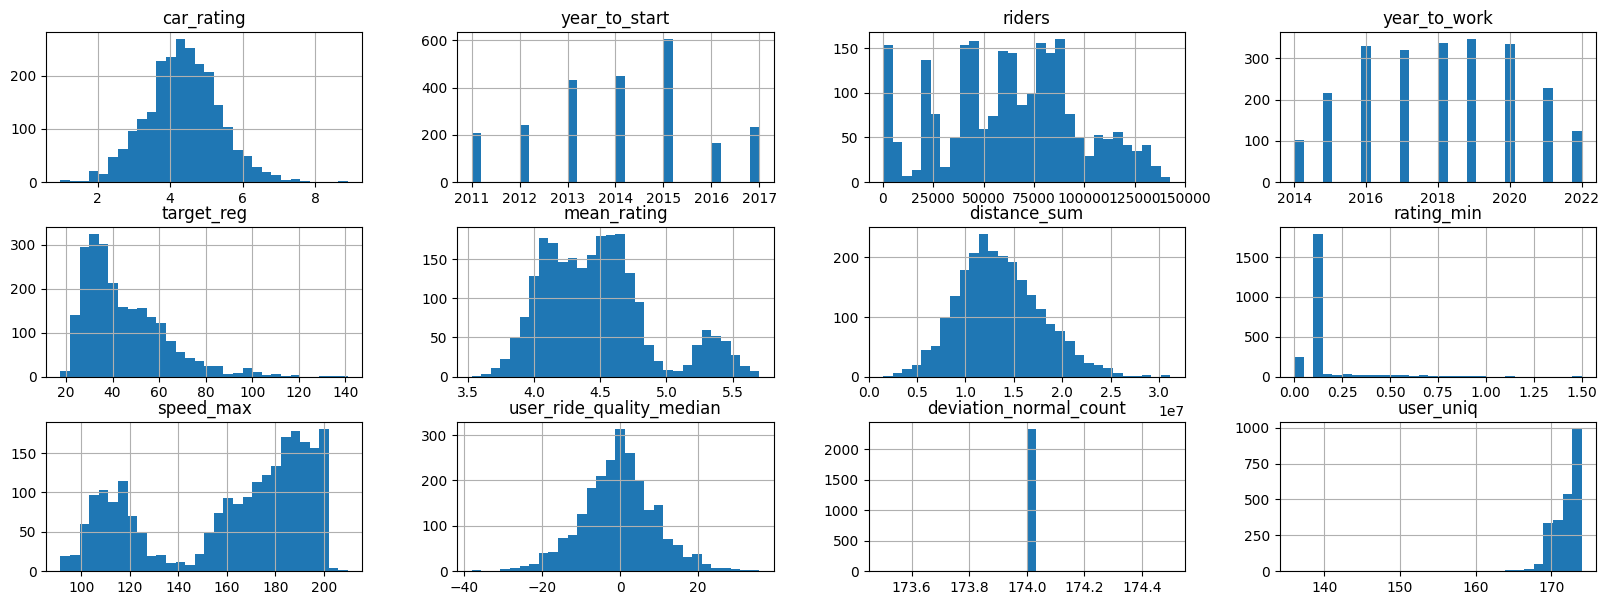

In [25]:
train.hist(figsize = (20, 7), layout = (-1, 4), bins=30);

In [26]:
train.describe()

,car_rating,year_to_start,riders,year_to_work,target_reg,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
count,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000,2.337000e+03,2337.000000,2337.000000,2337.000000,2337.0,2337.000000
mean,4.354292,2014.040650,63711.443731,2018.069748,44.947381,4.478831,1.356912e+07,0.138870,160.984884,-0.329339,174.0,171.624305
std,0.996954,1.685852,33755.012096,2.159484,17.647533,0.418588,4.253209e+06,0.163978,33.211161,9.581800,0.0,3.158088
min,0.980000,2011.000000,23.000000,2014.000000,17.640000,3.529885,1.478866e+06,0.000000,91.423508,-38.116345,174.0,136.000000
25%,3.740000,2013.000000,41053.000000,2016.000000,31.570000,4.155747,1.058758e+07,0.100000,123.609208,-6.141569,174.0,171.000000
50%,4.360000,2014.000000,64415.000000,2018.000000,40.010000,4.442989,1.321852e+07,0.100000,172.435742,-0.195860,174.0,172.000000
75%,5.000000,2015.000000,86515.000000,2020.000000,54.720000,4.675345,1.631788e+07,0.100000,188.597411,5.370422,174.0,173.000000
max,8.900000,2017.000000,142862.000000,2022.000000,141.130000,5.700747,3.119785e+07,1.500000,209.982840,35.770493,174.0,174.000000


In [27]:
for col in train.columns:
    print(f'Признак: {col} --> Уникальных значений: {train[col].nunique()}')

Признак: model --> Уникальных значений: 26
Признак: car_type --> Уникальных значений: 4
Признак: fuel_type --> Уникальных значений: 2
Признак: car_rating --> Уникальных значений: 269
Признак: year_to_start --> Уникальных значений: 7
Признак: riders --> Уникальных значений: 2306
Признак: year_to_work --> Уникальных значений: 9
Признак: target_reg --> Уникальных значений: 1835
Признак: target_class --> Уникальных значений: 9
Признак: mean_rating --> Уникальных значений: 2223
Признак: distance_sum --> Уникальных значений: 2337
Признак: rating_min --> Уникальных значений: 91
Признак: speed_max --> Уникальных значений: 1938
Признак: user_ride_quality_median --> Уникальных значений: 2337
Признак: deviation_normal_count --> Уникальных значений: 1
Признак: user_uniq --> Уникальных значений: 30


#### По гистограммам и статистикам видно, что возможно следует удалить колонку deviation_normal_count с константным значением и возможно колонки fuel_type и car_type с небольшой вариативностью.

При решении задачи шага 4.4.5 "Практический урок по бустингам"https://stepik.org/lesson/779920/step/5?unit=782494

На предложенных данных были получены результаты:
- CatBoostRegressor RMSE=11.9
- LGBMRegressor RMSE=12.3
- XGBRegressor RMSE=12.5

CatBoostRegressor ближе всех к порогу **RMSE=11.85**, но это результат для моделей с подобранными гиперпараметрами.   Было принято решение самому сделать предобработку данных и генерацию новых признаков: см. класс **DataTransform**

Кроме этого добавлен признак **target_class** для тестовой выборки получен как результат работы классификации видов поломок машин: ноутбук https://www.kaggle.com/code/saspav/hand-made-features-catboost

## Попробуем **lightautoml** на исходных данных

In [28]:
sub_pref = 'lama_'
start_time = print_msg('Обучение TabularAutoML ...')

task = Task('reg', loss='rmsle', metric='rmsle')

roles = {'target': 'target_reg'}

TIMEOUT = 6 * 600
N_FOLDS = 5
N_THREADS = 16
TEST_SIZE = 0.2
TARGET_NAME = 'target_reg'

# Настройка автоматической модели
automl = TabularAutoML(task=task,
                       timeout=TIMEOUT,
                       cpu_limit=N_THREADS,
                       memory_limit=48,
                       general_params={
                           'use_algos': 'auto',
                       },
                       reader_params={'n_jobs': N_THREADS,
                                      'cv': N_FOLDS,
                                      'random_state': RANDOM_SEED},
                       )

oof_predicts = automl.fit_predict(train, roles=roles, verbose=-1)
predict_test = automl.predict(test)

print_time(start_time)

print(f'OOF score: {mean_squared_error(train["target_reg"], oof_predicts.data[:, 0])}')

INFO:lightautoml.automl.presets.base:Stdout logging level is ERROR.
INFO:lightautoml.automl.presets.base:Task: reg

INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:
INFO:lightautoml.automl.presets.base:- time: 3600.00 seconds
INFO:lightautoml.automl.presets.base:- CPU: 16 cores
INFO:lightautoml.automl.presets.base:- memory: 48 GB

INFO:lightautoml.reader.base:Train data shape: (2337, 16)



Обучение TabularAutoML ...


INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []
INFO:lightautoml.automl.base:Layer 1 train process start. Time left 3588.72 secs
INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [5, 12, 22], 'embed_sizes': array([10, 11, 27], dtype=int32), 'data_size': 25}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -0.3494671317993192
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -0.3492301442882241
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -0.348925082815907
INFO3:lightautoml.ml

Время обработки: 5 мин 39.9 сек
OOF score: 87.60694767954587


In [29]:
max_num = get_max_num(log_file=MODELS_LOGS_REG) + 1

# Сохранение предсказаний в файл
submit_csv = f'{sub_pref}submit_{max_num:03}_reg.csv'
file_submit_csv = PREDICTIONS_DIR.joinpath(submit_csv)
submission = pd.DataFrame({'car_id': test.reset_index(names='car_id')['car_id'],
                           'target_reg': predict_test.data[:, 0]})
submission.to_csv(file_submit_csv, index=False)

print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 1.00000 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) 


## Скор на ЛБ: RMSE=19.2 - очень плохой результат, т.к. бустинги выдавали ~12

### Попробуем указать модели для обучения

In [30]:
sub_pref = 'lam2_'
start_time = print_msg('Обучение TabularAutoML ...')

task = Task('reg', loss='rmsle', metric='rmsle')

roles = {'target': 'target_reg'}

TIMEOUT = 6 * 600
N_FOLDS = 5
N_THREADS = 16
TEST_SIZE = 0.2
TARGET_NAME = 'target_reg'

# Настройка автоматической модели
automl = TabularAutoML(task=task,
                       timeout=TIMEOUT,
                       cpu_limit=N_THREADS,
                       general_params={'use_algos': [['rf',
                                                      'cb_tuned',
                                                      'xgb_tuned',
                                                      ],
                                                     ['lgb_tuned']
                                                     ],
                                       },
                       reader_params={'n_jobs': N_THREADS,
                                      'cv': N_FOLDS,
                                      'random_state': RANDOM_SEED},
                       )

oof_predicts = automl.fit_predict(train, roles=roles, verbose=-1)
predict_test = automl.predict(test)

print_time(start_time)

print(f'OOF score: {mean_squared_error(train["target_reg"], oof_predicts.data[:, 0])}')

INFO:lightautoml.automl.presets.base:Stdout logging level is ERROR.
INFO:lightautoml.automl.presets.base:Task: reg

INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:
INFO:lightautoml.automl.presets.base:- time: 3600.00 seconds
INFO:lightautoml.automl.presets.base:- CPU: 16 cores
INFO:lightautoml.automl.presets.base:- memory: 16 GB

INFO:lightautoml.reader.base:Train data shape: (2337, 16)



Обучение TabularAutoML ...


Выходные данные были обрезаны до нескольких последних строк (5000).
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
INFO2:lightautoml.ml_algo.random_forest:Score for RF model: -0.181124
INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Us

Время обработки: 10 мин 37.4 сек
OOF score: 145.13840222969776


In [31]:
# Сохранение предсказаний в файл
submit_csv = f'{sub_pref}submit_{max_num:03}_reg.csv'
file_submit_csv = PREDICTIONS_DIR.joinpath(submit_csv)
submission = pd.DataFrame({'car_id': test.reset_index(names='car_id')['car_id'],
                           'target_reg': predict_test.data[:, 0]})
submission.to_csv(file_submit_csv, index=False)

print(automl.create_model_str_desc())

Models on level 0:
	 5 averaged models Lvl_0_Pipe_0_Mod_0_RFSklearn
	 5 averaged models Lvl_0_Pipe_1_Mod_0_Tuned_CatBoost
	 5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_XGBoost

Final prediction for new objects (level 1) = 
	 1.00000 * (5 averaged models Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM) 


### Скор на ЛБ: RMSE=12.3 - гораздо лучше, чем TabularAutoML из коробки на исходных данных

In [34]:
# Загрузка результата работы классификатора поломок машин: используется как Псевдолейблинг
!mkdir -p predictions
!wget -q https://raw.githubusercontent.com/saspav/Introduction_Competitive_Data_Science/main/cb_submit_074_local.csv > /dev/null 2>&1
!wget -q https://raw.githubusercontent.com/saspav/Introduction_Competitive_Data_Science/main/sr_submit_100_reg.csv > /dev/null 2>&1
!mv cb_submit_074_local.csv predictions/
!mv sr_submit_100_reg.csv predictions/

### Загрузка и предобработка данных

In [35]:
!wget -q https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv
!wget -q https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv
!wget -q https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_info.csv
!wget -q https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv
!wget -q https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv
!wget -q https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv

In [36]:
cat_columns = ['model', 'car_type', 'fuel_type', 'target_class']
features2drop = ['car_id']
numeric_columns = []
SHOW_MIN_OUTPUT = True

# Чтение и предобработка данных
data_cls = DataTransform(use_catboost=True,
                         category_columns=cat_columns,
                         features2drop=features2drop,
                         )

# train_df, test_df = data_cls.make_agg_data()
train_df, test_df = data_cls.make_agg_data(file_with_target_class='cb_submit_074_local.csv')

# Добавление группировок по целевому признаку
train_df = data_cls.fit_transform(train_df)
test_df = data_cls.transform(test_df)

cat_columns = data_cls.category_columns

exclude_columns = [

]

exclude_columns.extend(data_cls.exclude_columns)

model_columns = [col for col in test_df.columns.to_list() if col not in exclude_columns]
cat_columns = [col for col in cat_columns if col in model_columns + features2drop]
num_columns = [col for col in model_columns if col not in cat_columns + features2drop]

exclude_columns = features2drop + exclude_columns

print('Категорийные колонки:', cat_columns)

print(f'Размер train_df = {train_df.shape}, test = {test_df.shape}')

train = train_df[model_columns + ['target_reg']]
target = train_df['target_reg']
test_df = test_df[model_columns].copy()

for col in cat_columns:
    train[col] = train[col].astype('category')
    test_df[col] = test_df[col].astype('category')

print('train.shape', train.shape, 'пропусков:', train.isna().sum().sum())
print('test.shape', test_df.drop(columns=features2drop, errors='ignore').shape,
      'пропусков:', test_df.isna().sum().sum())

Загрузка данных...
Время обработки: 12.2 сек
Сохраняем предобработанные данные...
Время обработки: 12.5 сек
Агрегация данных...
Время обработки: 7.4 сек
Сохраняем агрегированные данные...
Время обработки: 0.2 сек
Группировка по целевому признаку...
Время обработки: 0.0 сек
Исходный размер датасета в памяти равен 3.37 мб.
Конечный размер датасета в памяти равен 0.95 мб.
Экономия памяти = 71.8%
Исходный размер датасета в памяти равен 2.74 мб.
Конечный размер датасета в памяти равен 0.77 мб.
Экономия памяти = 71.8%
Категорийные колонки: ['model', 'car_type', 'fuel_type', 'target_class', 'mode_work_type']
Размер train_df = (2337, 192), test = (1913, 191)
train.shape (2337, 192) пропусков: 0
test.shape (1913, 191) пропусков: 0


In [37]:
sub_pref = 'lm_dp_'
start_time = print_msg('Обучение TabularAutoML ...')

task = Task('reg', loss='rmsle', metric='rmsle')

roles = {'target': 'target_reg'}

TIMEOUT = 6 * 600
N_FOLDS = 5
N_THREADS = 16
TEST_SIZE = 0.2
TARGET_NAME = 'target_reg'

# Настройка автоматической модели
automl = TabularAutoML(task=task,
                       timeout=TIMEOUT,
                       cpu_limit=N_THREADS,
                       memory_limit=48,
                       general_params={
                           'use_algos': 'auto',
                       },
                       reader_params={'n_jobs': N_THREADS,
                                      'cv': N_FOLDS,
                                      'random_state': RANDOM_SEED},
                       )

oof_predicts = automl.fit_predict(train, roles=roles, verbose=-1)
predict_test = automl.predict(test_df)

print_time(start_time)

print(f'OOF score: {mean_squared_error(train["target_reg"], oof_predicts.data[:, 0])}')

INFO:lightautoml.automl.presets.base:Stdout logging level is ERROR.
INFO:lightautoml.automl.presets.base:Task: reg

INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:
INFO:lightautoml.automl.presets.base:- time: 3600.00 seconds
INFO:lightautoml.automl.presets.base:- CPU: 16 cores
INFO:lightautoml.automl.presets.base:- memory: 48 GB

INFO:lightautoml.reader.base:Train data shape: (2337, 192)



Обучение TabularAutoML ...


INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []
INFO:lightautoml.automl.base:Layer 1 train process start. Time left 3590.24 secs
INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [0, 2, 3, 5, 7, 9, 12, 16, 18, 19, 24, 26, 28, 31, 33, 34, 39, 40, 52, 58, 66, 70, 74, 76, 78, 79, 80, 84, 87, 88, 94, 99, 101, 102, 104, 105, 108, 110, 112, 115, 120, 121, 123, 125, 126, 128, 132, 133, 141, 142, 148, 149, 151, 152, 153, 154, 156, 161, 162, 165, 168, 169, 170, 173, 174, 176, 178, 179, 180, 183, 184, 190, 197, 199, 200, 201, 207, 208, 216, 219, 220, 224, 227, 228, 231, 232, 238, 239, 244, 246, 252, 253, 264, 265, 268, 271, 273, 275, 278, 288, 295, 296, 298, 299, 300, 303, 307, 309, 314, 3

Время обработки: 14 мин 2.3 сек
OOF score: 42.06297302246094


In [38]:
# Сохранение предсказаний в файл
submit_csv = f'{sub_pref}submit_{max_num:03}_reg.csv'
file_submit_csv = PREDICTIONS_DIR.joinpath(submit_csv)
submission = pd.DataFrame({'car_id': test_df.reset_index(names='car_id')['car_id'],
                           'target_reg': predict_test.data[:, 0]})
submission.to_csv(file_submit_csv, index=False)

print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.05569 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.23884 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.58599 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.11948 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


## Скор на ЛБ: RMSE=6.25 - результат чуть хуже, чем у тюнингованных бустингов

### Попробуем указать модели для обучения

In [39]:
sub_pref = 'lm_dp2_'
start_time = print_msg('Обучение TabularAutoML ...')

task = Task('reg', loss='rmsle', metric='rmsle')

roles = {'target': 'target_reg'}

TIMEOUT = 6 * 600
N_FOLDS = 5
N_THREADS = 16
TEST_SIZE = 0.2
TARGET_NAME = 'target_reg'

# Настройка автоматической модели
automl = TabularAutoML(task=task,
                       timeout=TIMEOUT,
                       cpu_limit=N_THREADS,
                       general_params={'use_algos': [['rf',
                                                      'cb_tuned',
                                                      'xgb_tuned',
                                                      ],
                                                     ['lgb_tuned']
                                                     ],
                                       },
                       reader_params={'n_jobs': N_THREADS,
                                      'cv': N_FOLDS,
                                      'random_state': RANDOM_SEED},
                       )

oof_predicts = automl.fit_predict(train, roles=roles, verbose=-1)
predict_test = automl.predict(test_df)

print_time(start_time)

print(f'OOF score: {mean_squared_error(train["target_reg"], oof_predicts.data[:, 0])}')

INFO:lightautoml.automl.presets.base:Stdout logging level is ERROR.
INFO:lightautoml.automl.presets.base:Task: reg

INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:
INFO:lightautoml.automl.presets.base:- time: 3600.00 seconds
INFO:lightautoml.automl.presets.base:- CPU: 16 cores
INFO:lightautoml.automl.presets.base:- memory: 16 GB

INFO:lightautoml.reader.base:Train data shape: (2337, 192)



Обучение TabularAutoML ...


INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []
INFO:lightautoml.automl.base:Layer 1 train process start. Time left 3590.23 secs
INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_RFSklearn ...
DEBUG:lightautoml.ml_algo.base:Training params: {'bootstrap': True, 'ccp_alpha': 0.0, 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_samples_leaf': 32, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': 4, 'oob_score': False, 'random_state': 42, 'warm_start': False, 'criterion': 'squared_error'}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.1s
[Parallel(n_job

Время обработки: 18 мин 34.2 сек
OOF score: 46.24663162231445


In [40]:
# Сохранение предсказаний в файл
submit_csv = f'{sub_pref}submit_{max_num:03}_reg.csv'
file_submit_csv = PREDICTIONS_DIR.joinpath(submit_csv)
submission = pd.DataFrame({'car_id': test_df.reset_index(names='car_id')['car_id'],
                           'target_reg': predict_test.data[:, 0]})
submission.to_csv(file_submit_csv, index=False)

print(automl.create_model_str_desc())

Models on level 0:
	 5 averaged models Lvl_0_Pipe_0_Mod_0_RFSklearn
	 5 averaged models Lvl_0_Pipe_1_Mod_0_Tuned_CatBoost
	 5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_XGBoost

Final prediction for new objects (level 1) = 
	 1.00000 * (5 averaged models Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM) 


## Скор на ЛБ: RMSE=6.4 - результат чуть хуже, чем у TabularAutoML из коробки